In [64]:
import os

import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Load environment variables from .env file
load_dotenv()

True

In [65]:

# Load the crime index data
crime_data_path = r"C:\Users\Nick\PycharmProjects\holman-olympic-data\datasets\countries_health\Crime index by countries 2020.csv"
crime_df = pd.read_csv(crime_data_path, names=["country", "crime_index", "safety_index"])

# Normalize country names (lowercase and strip spaces)
crime_df["country"] = crime_df["country"].str.lower().str.strip()

# Display the first few rows
print("Crime Index Data:")
crime_df.head()


Crime Index Data:


,country,crime_index,safety_index
0,country,Crime Index,Safety Index
1,venezuela,84.49,15.51
2,papua new guinea,81.93,18.07
3,south africa,77.49,22.51
4,afghanistan,76.23,23.77


In [66]:
# Connect to the database
database_url = os.getenv("DATABASE_URL")
engine = create_engine(database_url, echo=False)


In [67]:
# Custom mapping for country names in the olympics medals data
country_code_mapping = {
    "ROC": "RUS"  # Replace ROC with RUS for Russia
}

# Load the olympics medals data
olympics_medals_df = pd.read_sql_table("olympics_medals", con=engine)

# Filter the rows for the 2020 Olympics
olympics_medals_2020_df = olympics_medals_df[olympics_medals_df["year"] == 2020]

# Replace 'ROC' with 'RUS' in the 'nation' column to normalize the country codes
olympics_medals_2020_df["nation"] = olympics_medals_2020_df["nation"].replace(country_code_mapping)

# Verify the change
olympics_medals_2020_df.head()

C:\Users\Nick\AppData\Local\Temp\ipykernel_11268\3853884759.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  olympics_medals_2020_df["nation"] = olympics_medals_2020_df["nation"].replace(country_code_mapping)


,nation,gold,silver,bronze,total,year
647,USA,39,41,33,113,2020
648,CHN,38,32,19,89,2020
649,JPN,27,14,17,58,2020
650,GBR,22,20,22,64,2020
651,AUS,17,7,22,46,2020


In [68]:
# Load the noc_mapping table so we can map the olympics_medals_2020_df to the country names in the crime_df
noc_mapping_df = pd.read_sql_table("noc_mapping", con=engine)
noc_mapping_df.head()

,country_name,noc_code
0,South Georgia,SGS
1,Grenada,GRD
2,Switzerland,CHE
3,Sierra Leone,SLE
4,Hungary,HUN


In [69]:
# Merge the olympics_medals_2020_df with the noc_mapping_df to get the country names
olympics_medals_2020_df = pd.merge(olympics_medals_2020_df, noc_mapping_df, how="left", left_on='nation', right_on='noc_code')
olympics_medals_2020_df.head()

,nation,gold,silver,bronze,total,year,country_name,noc_code
0,USA,39,41,33,113,2020,United States,USA
1,CHN,38,32,19,89,2020,China,CHN
2,JPN,27,14,17,58,2020,Japan,JPN
3,GBR,22,20,22,64,2020,United Kingdom,GBR
4,AUS,17,7,22,46,2020,Australia,AUS


In [71]:
# Lowercase the country_name column to match the crime_df
olympics_medals_2020_df["country_name"] = olympics_medals_2020_df["country_name"].str.lower()

# Merge the olympics_medals_2020_df with the crime_df to get the crime index data
olympics_medals_2020_df = pd.merge(olympics_medals_2020_df, crime_df, how="left", left_on='country_name', right_on='country')
olympics_medals_2020_df.head()

,nation,gold,silver,bronze,total,year,country_name,noc_code,country_x,crime_index_x,safety_index_x,country_y,crime_index_y,safety_index_y
0,USA,39,41,33,113,2020,united states,USA,united states,47.2,52.8,united states,47.2,52.8
1,CHN,38,32,19,89,2020,china,CHN,china,31.83,68.17,china,31.83,68.17
2,JPN,27,14,17,58,2020,japan,JPN,japan,20.66,79.34,japan,20.66,79.34
3,GBR,22,20,22,64,2020,united kingdom,GBR,united kingdom,43.71,56.29,united kingdom,43.71,56.29
4,AUS,17,7,22,46,2020,australia,AUS,australia,41.36,58.64,australia,41.36,58.64


Countries with High Medals and High Crime Index:
   nation  total  crime_index_x
0     USA    113          47.20
3     GBR     64          43.71
91    RUS     71          41.12


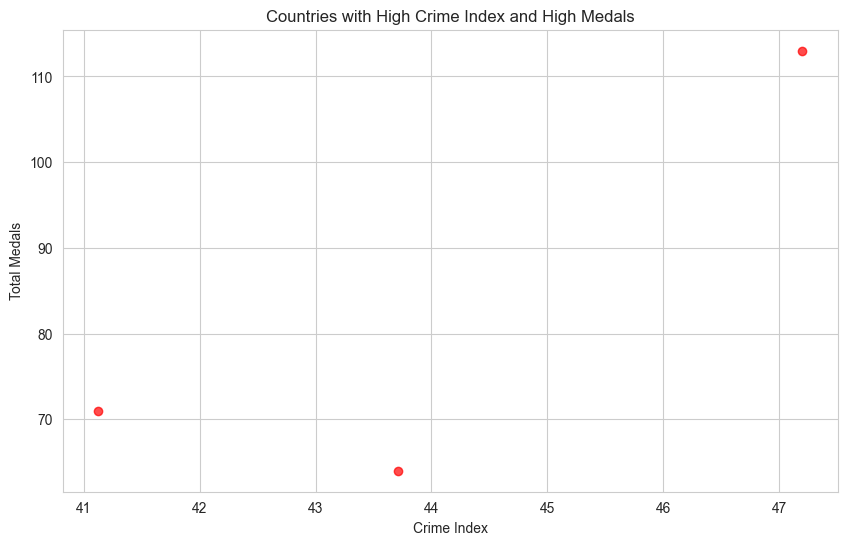

In [83]:
import matplotlib.pyplot as plt

olympics_medals_2020_df['crime_index_x'] = olympics_medals_2020_df['crime_index_x'].astype(float)

# Thresholds for 'high crime' and 'high medals'
high_crime_threshold = 40.0
high_medals_threshold = 50

# Filter countries meeting both conditions
high_crime_high_medals = olympics_medals_2020_df[
    (olympics_medals_2020_df['crime_index_x'] > high_crime_threshold) & 
    (olympics_medals_2020_df['total'] > high_medals_threshold)
]

# Display the results
print("Countries with High Medals and High Crime Index:")
print(high_crime_high_medals[['nation', 'total', 'crime_index_x']])

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(high_crime_high_medals['crime_index_x'], high_crime_high_medals['total'], color='red', alpha=0.7)
plt.title("Countries with High Crime Index and High Medals")
plt.xlabel("Crime Index")
plt.ylabel("Total Medals")
plt.grid(True)
plt.show()
